# 深度强化学习－用卷积神经网络实现AI玩Pie and Bomb游戏

《馅饼和炸弹》酝酿自《三体》。三体运动是有规律但不可预测的，三体人将其归纳为恒纪元和乱纪元两种状态是一种简化。在本游戏中，这两种状态是真实存在的，恒纪元天上掉馅饼，乱纪元天上掉炸弹，切换的时间随机没有规律，玩家的任务是收集馅饼，躲开炸弹。

## 一、PyGAME实现Pie and Bomb游戏

在这部分中，我们调用PyGame包实现了一个Flappy Bird游戏。通过PyGame，我们可以非常方便的加载图片、音频，来快速实现小游戏

### 1. 加载游戏所需的必要资源

In [1]:
# 加载游戏中的所有资源，包括图片以及音频
# 调用PyGame包，关于该包的安装，请参看：http://www.pygame.org/wiki/GettingStarted
import pygame

# 需要获取操作系统类型，故而调用sys包
import sys
def load():
    # 加载各类资源的函数
    # 精灵在不同状态下的图片
    PLAYER_PATH = (
            'assets/sprites/redbird-left.png',
            'assets/sprites/redbird-right.png',
    )

    # 背景图地址
    BACKGROUND_PATH = 'assets/sprites/background-black.png'

    # 馅饼图片所在的地址
    PIE_PATH = 'assets/sprites/pie1.png'

    # 炸弹图片所在的地址
    BOMB_PATH = 'assets/sprites/bomb4.png'

    IMAGES, SOUNDS, HITMASKS = {}, {}, {}

    # 加载成绩数字所需的图片
    IMAGES['numbers'] = (
        pygame.image.load('assets/sprites/0.png').convert_alpha(),
        pygame.image.load('assets/sprites/1.png').convert_alpha(),
        pygame.image.load('assets/sprites/2.png').convert_alpha(),
        pygame.image.load('assets/sprites/3.png').convert_alpha(),
        pygame.image.load('assets/sprites/4.png').convert_alpha(),
        pygame.image.load('assets/sprites/5.png').convert_alpha(),
        pygame.image.load('assets/sprites/6.png').convert_alpha(),
        pygame.image.load('assets/sprites/7.png').convert_alpha(),
        pygame.image.load('assets/sprites/8.png').convert_alpha(),
        pygame.image.load('assets/sprites/9.png').convert_alpha()
    )

    # 加载地面的图片
    IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

    # 加载声音文件（在不同的系统中，声音文件扩展名不同）
    if 'win' in sys.platform:
        soundExt = '.wav'
    else:
        soundExt = '.ogg'

    SOUNDS['die']    = pygame.mixer.Sound('assets/audio/die' + soundExt)
    SOUNDS['hit']    = pygame.mixer.Sound('assets/audio/hit' + soundExt)
    SOUNDS['point']  = pygame.mixer.Sound('assets/audio/point' + soundExt)
    SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
    SOUNDS['wing']   = pygame.mixer.Sound('assets/audio/wing' + soundExt)

    # 加载背景图
    IMAGES['background'] = pygame.image.load(BACKGROUND_PATH).convert()

    # s加载精灵图
    IMAGES['player'] = (
        pygame.transform.flip(pygame.image.load(PLAYER_PATH[1]).convert_alpha(), True, False),
        pygame.image.load(PLAYER_PATH[1]).convert_alpha(),
    )

    # 加载馅饼
    IMAGES['pie'] = (
        pygame.image.load(PIE_PATH).convert_alpha(),
    )

    # 加载炸弹
    IMAGES['bomb'] = (
        pygame.image.load(BOMB_PATH).convert_alpha(),
    )

    # 获得水管的蒙板
    HITMASKS['pie'] = (
        getHitmask(IMAGES['pie'][0]),
    )

    # 获得炸弹的蒙板
    HITMASKS['bomb'] = (
        getHitmask(IMAGES['bomb'][0]),
    )

    # 玩家的蒙板
    HITMASKS['player'] = (
        getHitmask(IMAGES['player'][0]),
        getHitmask(IMAGES['player'][1]),
    )

    #返回了三个字典，每个字典的值分别存储图像、声音和蒙板
    return IMAGES, SOUNDS, HITMASKS

def getHitmask(image):
    """根据图像的alpha，获得蒙板"""
    #所谓蒙板就是指将图像中的主体从整个图像中抠出来的技术，从而方便与其它的对象合成到一起
    #蒙板用一个boolean类型的列表来存储
    mask = []
    for x in range(image.get_width()):
        mask.append([])
        for y in range(image.get_height()):
            mask[x].append(bool(image.get_at((x,y))[3]))
    return mask

### 2. 实现Flappy Bird的游戏逻辑

In [2]:
# 加载程序所需的包
import time
import numpy as np
import sys
import random
import pygame
import pygame.surfarray as surfarray
from pygame.locals import *
from itertools import cycle

FPS = 30 #帧率
SCREENWIDTH  = 288 #屏幕的宽度
SCREENHEIGHT = 512 #屏幕的高度

pygame.init() #游戏初始化
FPSCLOCK = pygame.time.Clock() #定义程序时钟
SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT)) #定义屏幕对象
pygame.display.set_caption('Pie and Bomb') #设定窗口名称

IMAGES, SOUNDS, HITMASKS = load() #加载游戏资源
#PIPEGAPSIZE = 100 # 定义两个水管之间的宽度
BASEY = SCREENHEIGHT * 0.79 #设定基地的高度

# 设定小鸟属性：宽度、高度等
PLAYER_WIDTH = IMAGES['player'][0].get_width()
PLAYER_HEIGHT = IMAGES['player'][0].get_height()

# 设定馅饼属性：高度、宽度
PIE_WIDTH = IMAGES['pie'][0].get_width()
PIE_HEIGHT = IMAGES['pie'][0].get_height()

#背景宽度
BACKGROUND_WIDTH = IMAGES['background'].get_width()

#模式
MODE_BOMB = 0
MODE_PIE = 1

#PLAYER_INDEX_GEN = cycle([0, 1, 2, 1])

# 游戏模型类
class GameState:
    def __init__(self, downVelY, downInterval, pure_prob, modeChangeInterval, showScore):
        # 初始化
        # 初始成绩、玩家索引、迭代、循环迭代都为0
        self.score = self.playerIndex = self.frame = self.loopIter = 0
        self.showScore = showScore
        self.mode = MODE_BOMB #更快结束
        
        self.basex = 0
        # 地面的初始移位
        self.baseShift = IMAGES['base'].get_width() - BACKGROUND_WIDTH

        #设定玩家的初始位置
        self.playerx = int(SCREENWIDTH * 0.5 - PLAYER_WIDTH * 0.5)
        self.playery = int(BASEY-PLAYER_WIDTH)

        # 下落物体列表
        self.downObjects = []
        self.downVelY = downVelY          # 物体下落时y轴上的速度
        self.downInterval = downInterval
        self.lastDownIter = self.frame
        self.pure_prob = pure_prob
        
        self.modeChangeInterval = modeChangeInterval;
        self.lastModeChangeFrame = self.frame

        # 定义玩家的属性
        self.playerVelX    =  5    # 玩家在x轴上的速度
        
    def updateDownObject(self):
        #更新下降物体
        
        #模式
        if self.frame > 0 and self.frame % self.modeChangeInterval == 0 :
            self.mode = 1 - self.mode
            self.lastModeChangeFrame = self.frame
        
        #新物体
        if self.frame % self.downInterval == 0 :
            #if len(self.downObjects) < self. downCount:
                prob = random.uniform(0, 1)
                probPie = self.pure_prob if self.mode == MODE_PIE else 1-self.pure_prob
                objName = 'pie' if prob < probPie else 'bomb'
                self.downObjects.append({'name': objName, 'x':random.randint(0, SCREENWIDTH-PIE_WIDTH), 'y':0})
                self.lastDownIter = self.frame
        
        #下落
        for obj in self.downObjects:
            obj['y'] += self.downVelY
            
        #删除旧物体
        downObjects = filter(lambda obj:obj['y'] > BASEY,self.downObjects)


    def frame_step(self, input_actions):
        # input_actions是一个行动数组，分别存储了0或者1两个动作的激活情况
        # 游戏每一帧的循环
        pygame.event.pump()

        # 每一步的默认回报
        reward = 0.1
        terminal = False

        # 限定每一帧只能做一个动作
        if sum(input_actions) != 1:
            raise ValueError('Multiple input actions!')

        # input_actions[0] == 1: 对应什么都不做
        # input_actions[1] == 1: 对应左
        # input_actions[2] == 1: 对应右
        if input_actions[1] == 1:
            # 左
            self.playerIndex = 0
            self.playerx -= self.playerVelX
            if self.playerx < 0:
                self.playerx = 0
                #SOUNDS['wing'].play()
        elif input_actions[2] == 1:
            # 右
            self.playerIndex = 1
            self.playerx += self.playerVelX
            if self.playerx > SCREENWIDTH - PLAYER_WIDTH:
                self.playerx = SCREENWIDTH - PLAYER_WIDTH
                #SOUNDS['wing'].play()

        # 降落物体的移动
        self.updateDownObject()

        # 检查碰撞
        idxCrash= checkCrash({'x': self.playerx, 'y': self.playery,
                             'index': self.playerIndex},
                            self.downObjects)
        # 如果有碰撞发生，则游戏结束，terminal＝True
        if idxCrash>=0:
            if self.downObjects[idxCrash]['name'] == 'pie':
                self.downObjects.pop(idxCrash)
                self.score += 1
                #SOUNDS['point'].play()
                reward = 1
            else :
                #SOUNDS['hit'].play()
                #SOUNDS['die'].play()
                terminal = True
                self.__init__(self.downVelY, self.downInterval, self.pure_prob, self.modeChangeInterval, self.showScore)
                reward = -1

        self.frame += 1
        
        # 将所有角色都根据每个角色的坐标画到屏幕上
        SCREEN.blit(IMAGES['background'], (0,0))

        for obj in self.downObjects :
            SCREEN.blit(IMAGES[obj['name']][0], (obj['x'], obj['y']))

        SCREEN.blit(IMAGES['base'], (self.basex, BASEY))
        
        if self.showScore :
            # print score so player overlaps the score
            showScore(self.score)
            
        SCREEN.blit(IMAGES['player'][self.playerIndex],
                    (self.playerx, self.playery))

        # 将当前的游戏屏幕生成一个二维画面返回
        image_data = pygame.surfarray.array3d(pygame.display.get_surface())
        pygame.display.update()
        FPSCLOCK.tick(FPS)
        #print self.upperPipes[0]['y'] + PIPE_HEIGHT - int(BASEY * 0.2)
        # 该函数的输出有三个变量：游戏当前帧的游戏画面，当前获得的游戏得分，游戏是否已经结束
        return image_data, reward, terminal
    

def showScore(score):
    # 在屏幕上直接展示成绩的函数
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0 # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, downObjects):
    # 检测碰撞的函数，基本思路为：将每一个物体都看作是一个矩形区域，然后检查两个矩形区域是否有碰撞
    # 检查碰撞是细到每个对象的图像蒙板级别，而不单纯是看矩形之间的碰撞
    """returns True if player collders with base or pipes."""
    
    #返回值 object的index -1无碰撞
    
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # 检查小鸟是否与物体碰撞
    playerRect = pygame.Rect(player['x'], player['y'],
                  player['w'], player['h'])

    #for obj in downObjects :
    for i in range(len(downObjects)):
        obj = downObjects[i]
        # 上下管道矩形
        objRect = pygame.Rect(obj['x'], obj['y'], PIE_WIDTH, PIE_HEIGHT)

        # 获得每个元素的蒙板
        pHitMask = HITMASKS['player'][pi]
        oHitmask = HITMASKS['pie'][0]

        # 检查是否与上下管道相撞
        collide = pixelCollision(playerRect, objRect, pHitMask, oHitmask)

        if collide:
            return i

    return -1

def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """在像素级别检查两个物体是否发生碰撞"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    # 确定矩形框，并针对矩形框中的每个像素进行循环，查看两个对象是否碰撞
    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in range(rect.width):
        for y in range(rect.height):
            if hitmask1[x1+x][y1+y] and hitmask2[x2+x][y2+y]:
                return True
    return False

### 3. 对游戏做小测试

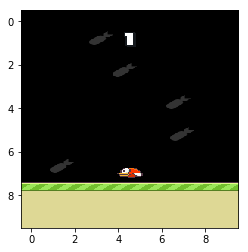

In [3]:

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# 新建一个游戏
game = GameState(5, 15, 0.5, 90, True)

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)

# 进行100步循环，并将每一帧的画面打印出来
for i in range(100):
    clear_output(wait = True)
    image_data, reward, terminal = game.frame_step([1,0,0])
    
    image = np.transpose(image_data, (1, 0, 2))
    img.set_data(image)
    img.autoscale()
    display(fig)

## 二、训练神经网络玩游戏

### 1. 定义网络

In [4]:

#  导入必需的包
from __future__ import print_function

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2 #需要安装OpenCV的包
import sys
sys.path.append("game/")
import random
import numpy as np
from collections import deque


# 定义一系列常数，其中，epsilon为每周期随机输出一个动作的概率
GAME = 'pie and bomb' # 游戏名称
ACTIONS = 3 # 有效输出动作的个数
GAMMA = 0.99 # 强化学习中未来的衰减率
OBSERVE = 10000. # 训练之前的时间步，需要先观察10000帧
EXPLORE = 3000000. # 退火所需的时间步，所谓的退火就是指随机选择率epsilon逐渐变小
FINAL_EPSILON = 0.0001 # epsilon的最终值
INITIAL_EPSILON = 0.1 # epsilon的初始值
REPLAY_MEMORY = 50000 # 最多记忆多少帧训练数据
BATCH = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出
INPUT_IMAGE_SIZE = 64

In [5]:

# 创建一个多层CNN网络，该网络接收的输入为4帧画面，输出为每个可能动作对应的Q函数值
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一层卷积，从4通道到32通道，窗口大小8，跳跃间隔4，填空白2
        self.conv1 = nn.Conv2d(4, 32, 8, 4, padding = 2)
        # Pooling层，窗口2*2
        self.pool = nn.MaxPool2d(2, 2)
        # 第二层卷积，从32通道到64通道，窗口大小4，跳跃间隔2，填空白1
        self.conv2 = nn.Conv2d(32, 64, 4, 2, padding = 1)
        # 第二个Pooling层，窗口2＊2，空白1
        self.pool2 = nn.MaxPool2d(2, 2, padding = 1)
        # 第三层卷积层，输入输出通道都是64，填空白为1
        self.conv3 = nn.Conv2d(64, 64, 3, 1, padding = 1)
        
        # 最后有两层全链接层
        self.fc_sz = int( 1600 * (INPUT_IMAGE_SIZE*INPUT_IMAGE_SIZE) /(80*80) )
        self.fc1 = nn.Linear(self.fc_sz, 256)
        self.fc2 = nn.Linear(256, ACTIONS)

    def forward(self, x):
        # 输入为一个batch的数据，每一个为前后相连的4张图像，每个图像为80*80的大小
        # x的尺寸为：batch_size, 4, 80, 80
        x = self.conv1(x)
        # x的尺寸为：batch_size, 32, 20, 20
        x = F.relu(x)
        x = self.pool(x)
        # x的尺寸为：batch_size, 32, 10, 10
        x = F.relu(self.conv2(x))
        # x的尺寸为：batch_size, 64, 5, 5
        #x = self.pool2(x)
        x = F.relu(self.conv3(x))
        # x的尺寸为：batch_size, 64, 5, 5
        #x = self.pool2(x)
        # 将x设为1600维的向量, batch_size, 1600
        x = x.view(-1, self.fc_sz)
        x = F.relu(self.fc1(x))
        readout = self.fc2(x)
        return readout, x
    def init(self):
        # 初始化所有的网络权重
        self.conv1.weight.data =  torch.abs(0.01 * torch.randn(self.conv1.weight.size()))
        self.conv2.weight.data =  torch.abs(0.01 * torch.randn(self.conv2.weight.size()))
        self.conv3.weight.data =  torch.abs(0.01 * torch.randn(self.conv3.weight.size()))
        self.fc1.weight.data = torch.abs(0.01 * torch.randn(self.fc1.weight.size()))
        self.fc2.weight.data = torch.abs(0.01 * torch.randn(self.fc2.weight.size()))
        self.conv1.bias.data = torch.ones(self.conv1.bias.size()) * 0.01
        self.conv2.bias.data = torch.ones(self.conv2.bias.size()) * 0.01
        self.conv3.bias.data = torch.ones(self.conv3.bias.size()) * 0.01
        self.fc1.bias.data = torch.ones(self.fc1.bias.size()) * 0.01
        self.fc2.bias.data = torch.ones(self.fc2.bias.size()) * 0.01

In [6]:
# 开始在内存／GPU上定义一个网络
use_cuda = torch.cuda.is_available() #检测本台机器中是否有GPU

# 创建一个神经网络
#net = Net()
# 初始化网络权重。之所以自定义初始化过程是为了增加神经网络权重的多样性
#net.init()

#加载
net = torch.load('saving_nets_5/pie and bomb-dqn440000.txt')

# 如果有GPU，就把神经网络全部搬到GPU内存中做运算
net = net.cuda() if use_cuda else net

# 定义损失函数为MSE
criterion = nn.MSELoss().cuda() if use_cuda else nn.MSELoss()
# 定义优化器，并设置初始学习率维10^-6
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6 )

# 开启一个游戏进程，开始与游戏引擎通话
game_state = GameState(5, 15, 0.8, 90, False)

# 学习样本的存储区域deque是一个类似于list的存储容器
D = deque()

# 状态打印log记录位置
#a_file = open("logs_" + GAME + "/readout.txt", 'w')
#h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# 将游戏设置为初始状态，并获得一个 INPUT_IMAGE_SIZE*INPUT_IMAGE_SIZE 的游戏湖面
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = cv2.cvtColor(cv2.resize(x_t, (INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)), cv2.COLOR_BGR2GRAY)
ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)

# 将初始的游戏画面叠加成4张作为神经网络的初始输入状态s_t
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)

# 设置初始的epsilon（采取随机行动的概率），并准备训练
epsilon = INITIAL_EPSILON
epsilon = 0.06
t = 0

#print(x_t)
#print(r_0)

import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### 2. 边做边学的核心算法

该算法分为三个阶段：

1、按照Epsilon贪婪算法采取一次行动；
2、将选择好的行动输入给游戏引擎，得到下一帧的状态，并生成本帧的训练数据
3、开始训练：

In [ ]:
# 记录每轮平均得分的容器
start = time.time()
scores = []
all_turn_scores = []
loss_rec = 0
while "flappy bird" != "angry bird":
    # 开始游戏循环
    ######################################################
    ##########首先，按照贪婪策略选择一个行动 ##################
    s = Variable(torch.from_numpy(s_t).type(torch.FloatTensor))
    s = s.cuda() if use_cuda else s
    s = s.view(-1, s.size()[0], s.size()[1], s.size()[2])
    # 获取当前时刻的游戏画面，输入到神经网络中
    readout, h_fc1 = net(s)
    # 神经网络产生的输出为readout：选择每一个行动的预期Q值
    readout = readout.cpu() if use_cuda else readout
    # readout为一个二维向量，分别对应每一个动作的预期Q值
    readout_t = readout.data.numpy()[0]

    # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
    # 1-epsilon的概率按照预期输出最大的Q值给出行动
    a_t = np.zeros([ACTIONS])
    action_index = 0
    if t % FRAME_PER_ACTION == 0:
        # 如果当前帧可以行动，则
        if random.random() <= epsilon:
            # 产生随机行动
            #print("----------Random Action----------")
            action_index = random.randrange(ACTIONS)
        else:
            # 选择神经网络判断的预期Q最大的行动
            action_index = np.argmax(readout_t)
        a_t[action_index] = 1
    else:
        a_t[0] = 1 # do nothing

    # 模拟退火：让epsilon开始降低
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

    ######################################################################### 
    ##########其次，将选择好的行动输入给游戏引擎，并得到下一帧的状态 ################### 
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    # 返回的x_t1_colored为游戏画面，r_t为本轮的得分，terminal为游戏在本轮是否已经结束
    
    # 记录一下每一步的成绩
    scores.append(r_t)
    if terminal:
        # 当游戏结束的时候，计算一下本轮的总成绩，并将总成绩存储到all_turn_scores中
        all_turn_scores.append(sum(scores))
        scores = []
    
    # 对游戏的原始画面做相应的处理，从而变成一张INPUT_IMAGE_SIZE*INPUT_IMAGE_SIZE的，朴素的（无背景画面）的图
    x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)), cv2.COLOR_BGR2GRAY)
    ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
    x_t1 = np.reshape(x_t1, (1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE))
    # 将当前帧的画面和前三帧的画面合并起来作为Agent获得的环境反馈结果
    s_t1 = np.append(x_t1, s_t[:3, :, :], axis=0)
    # 生成一个训练数据，分别将本帧的输入画面s_t,本帧的行动a_t，得到的环境回报r_t以及环境被转换的新状态s_t1存到D中
    D.append((s_t, a_t, r_t, s_t1, terminal))
    if len(D) > REPLAY_MEMORY:
        # 如果D中的元素已满，则扔掉最老的一条训练数据
        D.popleft()

    ######################################################################### 
    ##########最后，当运行周期超过一定次数后开始训练神经网络 ################### 
    if t > OBSERVE:
        # 从D中随机采样出一个batch的训练数据
        minibatch = random.sample(D, BATCH)
        optimizer.zero_grad()

        # 将这个batch中的s变量都分别存放到列表中
        s_j_batch = [d[0] for d in minibatch]
        a_batch = [d[1] for d in minibatch]
        r_batch = [d[2] for d in minibatch]
        s_j1_batch = [d[3] for d in minibatch]

        # 接下来，要根据s_j1_batch，神经网络给出预估的未来Q值
        
        s = Variable(torch.FloatTensor(np.array(s_j1_batch, dtype=float)))
        s = s.cuda() if use_cuda else s
        readout, h_fc1 = net(s)
        readout = readout.cpu() if use_cuda else readout
        readout_j1_batch = readout.data.numpy()
        # readout_j1_batch存储了一个minibatch中的所有未来一步的Q预估值
        # 根据Q的预估值，当前的反馈r，以及游戏是否结束，更新待训练的目标函数值
        y_batch = []
        for i in range(0, len(minibatch)):
            terminal = minibatch[i][4]
            # 当游戏结束的时候，则用环境的反馈作为目标，否则用下一状态的Q值＋本期的环境反馈
            if terminal:
                y_batch.append(r_batch[i])
            else:
                y_batch.append(r_batch[i] + GAMMA * np.max(readout_j1_batch[i]))

        # 开始梯度更新
        y = Variable(torch.FloatTensor(y_batch))
        a = Variable(torch.FloatTensor(a_batch))
        s = Variable(torch.FloatTensor(np.array(s_j_batch, dtype=float)))
        if use_cuda:
            y = y.cuda()
            a = a.cuda()
            s = s.cuda()
        # 计算s_j_batch的Q值
        readout, h_fc1 = net(s)
        readout_action = readout.mul(a).sum(1)
        # 根据s_j_batch下所选择的预估Q和目标y的Q值的差来作为损失函数训练网络
        loss = criterion(readout_action, y)
        loss.backward()
        optimizer.step()
        if t % 1000 == 0:
            loss_rec = loss.data[0]
            #print('损失函数：', loss.data[0])
       

    # 将状态更新一次，时间步＋1
    s_t = s_t1
    t += 1

    # 每隔 10000 次循环，存储一下网络
    if t % 10000 == 0:
        torch.save(net, 'saving_nets/' + GAME + '-dqn' + str(t) + '.txt')
    
    # 状态信息的转化，基本分为Observe，explore和train三个阶段
    # Observe没有训练，explore开始训练，并且开始模拟退火，train模拟退火结束
    state = ""
    if t <= OBSERVE:
        state = "observe"
    elif t > OBSERVE and t <= OBSERVE + EXPLORE:
        state = "explore"
    else:
        state = "train"
        
    # 打印当前运行的一些基本数据，分别输出到屏幕以及log文件中
    if t % 1000 == 0:
        sss = "时间步 {}/（{}） 状态 {}/ Loss {:e}/ Epsilon {:.2f}/ 行动 {}/ 奖励 {}/ Q_MAX {:e}/ 轮得分 {:.2f}".format(
            t, time_since(start), state, loss_rec, epsilon, action_index, r_t, np.max(readout_t), np.mean(all_turn_scores[-1000:]))
        print(sss)
        f = open('log_file.txt', 'a')
        f.write(sss + '\n')
        f.close()
    # write info to files
    

C:\ProgramData\Anaconda3\envs\tf36\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\envs\tf36\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


时间步 1000/（0m 34s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 1/ 奖励 0.1/ Q_MAX 1.088877e+01/ 轮得分 nan
时间步 2000/（1m 7s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.180499e+01/ 轮得分 nan
时间步 3000/（1m 40s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.167113e+01/ 轮得分 nan
时间步 4000/（2m 13s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.145040e+01/ 轮得分 nan
时间步 5000/（2m 46s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.159599e+01/ 轮得分 nan
时间步 6000/（3m 19s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 1/ 奖励 0.1/ Q_MAX 1.139811e+01/ 轮得分 nan
时间步 7000/（3m 52s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.153592e+01/ 轮得分 351.30
时间步 8000/（4m 25s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 1/ 奖励 0.1/ Q_MAX 1.120314e+01/ 轮得分 351.30
时间步 9000/（4m 58s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 1/ 奖励 0.1/ Q_MAX 1.170210e+01/ 轮得分 351.30


C:\ProgramData\Anaconda3\envs\tf36\lib\site-packages\torch\serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


时间步 10000/（5m 31s） 状态 observe/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.120602e+01/ 轮得分 351.30
时间步 11000/（6m 58s） 状态 explore/ Loss 0.000000e+00/ Epsilon 0.06/ 行动 1/ 奖励 0.1/ Q_MAX 1.166650e+01/ 轮得分 351.30
时间步 12000/（8m 25s） 状态 explore/ Loss 1.194824e-02/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.061639e+01/ 轮得分 351.30
时间步 13000/（9m 51s） 状态 explore/ Loss 1.625130e-02/ Epsilon 0.06/ 行动 0/ 奖励 0.1/ Q_MAX 1.165906e+01/ 轮得分 351.30
时间步 14000/（11m 18s） 状态 explore/ Loss 9.844925e-03/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.074953e+01/ 轮得分 351.30
时间步 15000/（12m 44s） 状态 explore/ Loss 1.075792e-02/ Epsilon 0.06/ 行动 2/ 奖励 0.1/ Q_MAX 1.192516e+01/ 轮得分 493.33
时间步 16000/（14m 10s） 状态 explore/ Loss 9.893207e-03/ Epsilon 0.06/ 行动 1/ 奖励 0.1/ Q_MAX 1.157956e+01/ 轮得分 493.33


2851


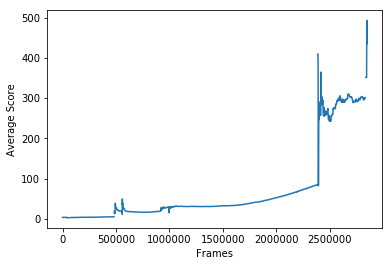

In [23]:
f = open('final_log_file.txt', 'r')
line = f.read().strip().split('\n')
values = []
for ln in line:
    segs = ln.split('/')
    values.append(float(segs[-1].split(' ')[-1]))
print(len(values))
plt.figure()
plt.plot(np.arange(len(values))*1000, values)
plt.xlabel('Frames')
plt.ylabel('Average Score')
plt.show()

In [19]:
#net = torch.load('final_model_20000.mdl')
#net = torch.load('final_model_60000.mdl')
net = torch.load('final_model_1710000.mdl')
#net = torch.load('final_model.mdl')
FINAL_EPSILON = 0.0001 # epsilon的最终值
BATCH = 32 # 每一个批次的数据记录条数
FRAME_PER_ACTION = 1 # 每间隔多少时间完成一次有效动作的输出

In [20]:
# 开始在内存／GPU上定义一个网络
use_cuda = torch.cuda.is_available() #检测本台机器中是否有GPU

# 如果有GPU，就把神经网络全部搬到GPU内存中做运算
net = net.cuda() if use_cuda else net

# 开启一个游戏进程，开始与游戏引擎通话
game_state = GameState(5, 15, 0.8, 90, False)

# 状态打印log记录位置
#a_file = open("logs_" + GAME + "/readout.txt", 'w')
#h_file = open("logs_" + GAME + "/hidden.txt", 'w')

# 将游戏设置为初始状态，并获得一个INPUT_IMAGE_SIZE*INPUT_IMAGE_SIZE的游戏湖面
do_nothing = np.zeros(ACTIONS)
do_nothing[0] = 1
x_t, r_0, terminal = game_state.frame_step(do_nothing)
x_t = cv2.cvtColor(cv2.resize(x_t, (INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)), cv2.COLOR_BGR2GRAY)
ret, x_t = cv2.threshold(x_t,1,255,cv2.THRESH_BINARY)

# 将初始的游戏画面叠加成4张作为神经网络的初始输入状态s_t
s_t = np.stack((x_t, x_t, x_t, x_t), axis=0)

# 设置初始的epsilon（采取随机行动的概率），并准备训练
epsilon = FINAL_EPSILON
t = 0# 记录每轮平均得分的容器
scores = []
all_turn_scores = []

fig = plt.figure()
axe = fig.add_subplot(111)
dat = np.zeros((10, 10))
img = axe.imshow(dat)
while "flappy bird" != "angry bird":
    # 开始游戏循环
    ######################################################
    ##########首先，按照贪婪策略选择一个行动 ##################
    s = Variable(torch.from_numpy(s_t).type(torch.FloatTensor))
    s = s.cuda() if use_cuda else s
    s = s.view(-1, s.size()[0], s.size()[1], s.size()[2])
    # 获取当前时刻的游戏画面，输入到神经网络中
    readout, h_fc1 = net(s)
    # 神经网络产生的输出为readout：选择每一个行动的预期Q值
    readout = readout.cpu() if use_cuda else readout
    # readout为一个二维向量，分别对应每一个动作的预期Q值
    readout_t = readout.data.numpy()[0]

    # 按照epsilon贪婪策略产生小鸟的行动，即以epsilon的概率随机输出行动或者以
    # 1-epsilon的概率按照预期输出最大的Q值给出行动
    a_t = np.zeros([ACTIONS])
    action_index = 0
    if t % FRAME_PER_ACTION == 0:
        # 如果当前帧可以行动，则
        if random.random() <= epsilon:
            # 产生随机行动
            #print("----------Random Action----------")
            action_index = random.randrange(ACTIONS)
        else:
            # 选择神经网络判断的预期Q最大的行动
            action_index = np.argmax(readout_t)
        a_t[action_index] = 1
    else:
        a_t[0] = 1 # do nothing
    ######################################################################### 
    ##########其次，将选择好的行动输入给游戏引擎，并得到下一帧的状态 ################### 
    x_t1_colored, r_t, terminal = game_state.frame_step(a_t)
    # 返回的x_t1_colored为游戏画面，r_t为本轮的得分，terminal为游戏在本轮是否已经结束
    
    # 记录一下每一步的成绩
    scores.append(r_t)
    if terminal:
        # 当游戏结束的时候，计算一下本轮的总成绩，并将总成绩存储到all_turn_scores中
        all_turn_scores.append(sum(scores))
        scores = []
    
    # 对游戏的原始画面做相应的处理，从而变成一张INPUT_IMAGE_SIZE*INPUT_IMAGE_SIZE的，朴素的（无背景画面）的图
    x_t1 = cv2.cvtColor(cv2.resize(x_t1_colored, (INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)), cv2.COLOR_BGR2GRAY)
    ret, x_t1 = cv2.threshold(x_t1, 1, 255, cv2.THRESH_BINARY)
    x_t1 = np.reshape(x_t1, (1, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE))
    # 将当前帧的画面和前三帧的画面合并起来作为Agent获得的环境反馈结果
    s_t1 = np.append(x_t1, s_t[:3, :, :], axis=0)
    s_t = s_t1
    t += 1
    clear_output(wait = True)
    
    image = np.transpose(x_t1_colored, (1, 0, 2))
    img.set_data(image)
    img.autoscale()
    display(fig)

KeyboardInterrupt: 